#Introduction
CISC 452 Project - Hurricane Trajectory and Intensity Prediction (LSTM)

*   Description: The following code trains a network to predict the next latitude, longtitude, wind pressure, wind speed, and storm direction in 6 hours given the past values from 24 hours (6 hour time intervals). The predictions from the model are then fed back into the model as input, to predict the latitude, longtitude, wind pressure, wind speed and storm direction at 24 hours.


*   Citation: Functions multivariate_data, plot_train_history & multi_step_plot are from https://www.tensorflow.org/tutorials/structured_data/time_series?fbclid=IwAR2wmmrcGwp_7n_pBtvJv9yfNYQMiRqHviVCKsSIEgVW8TMHxb9kYHktSsA



By: Ashley Drouillard | 10183354 | 14aad4 | Group 15

In [2]:
!pip install tensorflow-gpu==2.0.0rc numpy tqdm matplotlib --no-cache-dir

     |████████████████████████████████| 380.5MB 1.3MB/s 
     |████████████████████████████████| 501kB 35.3MB/s 
     |████████████████████████████████| 4.3MB 38.7MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import random as rand
from sklearn import preprocessing

import datetime as dt
import dateutil.parser

from tqdm import tqdm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [0]:
import pickle

In [5]:
tf.__version__

'2.0.0-rc0'

#Data Visualization

##Folium
Plots Longtitude and Latitude points on a map

In [0]:
import folium
from folium import IFrame
    
def plot_path(colour,points,pres,map):
    #fadd lines
    folium.PolyLine(points, color=colour, weight=2.5, opacity=1).add_to(map)

## Multi Step Plot
Function to plot history, predicted, and actual points on a graph.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps
  
def multi_step_plot(history, true_future, prediction, title=None):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

## Plot Training History
Function to plot the training and validation loss over time.

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

# Dataset Processing



*   Load data from csv
*   Filter out bad data (ensure timestamps are 6 hour intervals apart, remove storms that don't contain enough data/missing data)


*   Normalize the data





In [9]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import the raw IBtracs hurricane data stored on GitHub
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/NA_basin.csv'
data = pd.read_csv(url, header=0)

Season = (data.SEASON > 1980)
df = data[Season]

df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,...,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
4184,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-06 18:00,TS,18.4,-83.6,30,1006,hurdat_atl,main,300,300,O_____________,hurdat_atl,AL031981,18.4,-83.6,,TD,30,1006,-1,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,8,92
4185,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 0:00,TS,18.4,-82.7,30,1006,hurdat_atl,main,335,328,O_____________,hurdat_atl,AL031981,18.4,-82.7,,TD,30,1006,-1,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,9,85
4186,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 6:00,TS,18.6,-81.7,30,1005,hurdat_atl,main,333,300,O_____________,hurdat_atl,AL031981,18.6,-81.7,,TD,30,1005,-1,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11,74
4187,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 12:00,TS,19.0,-80.6,35,1003,hurdat_atl,main,248,219,O_____________,hurdat_atl,AL031981,19.0,-80.6,,TS,35,1003,0,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11,62
4188,1981127N18276,1981,35,NaN,CS,ARLENE,1981-05-07 18:00,TS,19.6,-79.7,40,1000,hurdat_atl,main,199,148,O_____________,hurdat_atl,AL031981,19.6,-79.7,,TS,40,1000,0,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,11,53


In [10]:
# Sort Storms by Storm ID (SID)
hurricane_SID = []
for i in range(1, len(df)):
  if (df.iloc[i].SID not in hurricane_SID):
    hurricane_SID.append(df.iloc[i].SID)

print(hurricane_SID)
print(len(hurricane_SID))

['1981127N18276', '1981181N36295', '1981215N36292', '1981219N11334', '1981244N30287', '1981247N16300', '1981250N15306', '1981255N14311', '1981265N14328', '1981303N25313', '1981307N17279', '1981317N31286', '1982154N22273', '1982169N26274', '1982241N14338', '1982252N26269', '1982257N20291', '1982274N25295', '1983228N27270', '1983236N26284', '1983254N30296', '1983270N28287', '1984231N33295', '1984242N11309', '1984244N13319', '1984244N37293', '1984253N29283', '1984258N20264', '1984260N14339', '1984261N29295', '1984267N31302', '1984270N23287', '1984281N24291', '1984311N15291', '1984348N35300', '1985197N29296', '1985202N26275', '1985222N32280', '1985224N18279', '1985240N20286', '1985259N24289', '1985260N13336', '1985265N30286', '1985280N18291', '1985299N25270', '1985320N21296', '1986156N26284', '1986175N26273', '1986226N30276', '1986250N11308', '1986254N22309', '1986323N23297', '1987220N34283', '1987222N26266', '1987230N15340', '1987249N15329', '1987252N11342', '1987263N10309', '1987282N1527

In [0]:
def CleanStorm(interval,storm):
  toRemove = []
  lastCleanTime = dateutil.parser.parse(storm['ISO_TIME'].iloc[0])
  # check if the last correct time minus the current time is in the correct interval
  for i in range(1,len(storm)):
    nextTime = dateutil.parser.parse(storm['ISO_TIME'].iloc[i])
    tDelta = nextTime - lastCleanTime
    if tDelta == interval:
      lastCleanTime = nextTime
    else:
      toRemove.append(storm.iloc[i])

  # Remove the bad data
  storm = storm.set_index("ISO_TIME")
  for r in toRemove:
    storm.drop(r['ISO_TIME'], axis=0)
  return storm


In [12]:
# Clean storms
hurricane_SID_remove = []

for i in range(0, len(hurricane_SID)):
  hurricanes = []

  # Columns to filter
  filter_SID = (df.SID.str.strip() == hurricane_SID[i])
  filtered_data = df[filter_SID]

  filtered_data = CleanStorm(6, filtered_data)
  if (len(filtered_data) < 12):
    hurricane_SID_remove.append(hurricane_SID[i])

for storm in hurricane_SID_remove:
  hurricane_SID.remove(storm)

print(len(hurricane_SID))

456


In [13]:
# First first 80% of the rows rows of the data will be 
# the training dataset, and there remaining will be the validation dataset.
TRAIN_SPLIT = int(len(hurricane_SID) * 0.8)

# Setting seed to ensure reproducibility.
tf.random.set_seed(13)

print(TRAIN_SPLIT)

364


In [14]:
features_considered = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'STORM_DIR']

features = df[features_considered]
features.index = df['ISO_TIME']

features.head()

,LAT,LON,WMO_WIND,WMO_PRES,STORM_DIR
ISO_TIME,,,,,
1981-05-06 18:00,18.4,-83.6,30,1006,92
1981-05-07 0:00,18.4,-82.7,30,1006,85
1981-05-07 6:00,18.6,-81.7,30,1005,74
1981-05-07 12:00,19.0,-80.6,35,1003,62
1981-05-07 18:00,19.6,-79.7,40,1000,53


#Training and Testing Data

In [0]:
# Normalize Data
dataset = features.values

data_min = dataset.min(axis=0)
data_max = dataset.max(axis=0)

dataset = (dataset-data_min)/(data_max-data_min)

In [0]:
# Helper Functions
def retreiveDatasetByName(sid, ds, ds_values):
  filtered_ds_values = []
  for i in range(len(ds)):
    if (ds.iloc[i].SID == sid):
      filtered_ds_values.append(ds_values[i])
  return np.array(filtered_ds_values)

def retreiveSIDByYear(year):
  sid_year = []
  for sid in hurricane_SID:
    if (sid[0:4] == str(year)):
      sid_year.append(sid)
  return sid_year

In [0]:
# Create list of data for each storm
hurricanes_by_SID = []
j = 0
for sid in hurricane_SID:
  print(j)
  hurricane = retreiveDatasetByName(sid, df, dataset)
  hurricanes_by_SID.append(hurricane)
  j += 1

In [0]:
# Save hurricanes_by_SID into a file
with open("storms.txt", "wb") as fp:   #Pickling
  pickle.dump(hurricanes_by_SID, fp)

In [0]:
# Load the hurricanes_by_SID
# (To avoid having to create the list each time)
with open("storms.txt", "rb") as fp:   # Unpickling
  hurricanes_by_SID = pickle.load(fp)

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return data, labels 

In [18]:
def longest(list1):
    longest_list = max(len(elem) for elem in list1)
    return longest_list

def shortest(list1):
  shortest_list = min(len(elem) for elem in list1)
  return shortest_list

longest_storm = longest(hurricanes_by_SID)
print(longest_storm)
shortest_storm = shortest(hurricanes_by_SID)
print(shortest_storm)

96
12


In [0]:
future_target = 1
past_history = 4
STEP = 1

def setUpTrainingAndTestingData(start_index, end_index, feature):

  x_train = []
  y_train = []

  for i in range(start_index, end_index):
    hurricane = hurricanes_by_SID[i]
    for j in range(0,len(hurricane),shortest_storm):
      hurricane_data = hurricane[j:j+shortest_storm]

      x, y = multivariate_data(hurricane_data, hurricane_data[:,feature],
                                                        0, None,
                                                        past_history, future_target,
                                                        STEP)
      x_train = x_train + x
      y_train = y_train + y
  
  return np.array(x_train), np.array(y_train)


In [0]:
lat_index = 0
lon_index = 1
wind_index = 2
pres_index = 3
dir_index = 4

# Latitude
x_train_lat, y_train_lat = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = lat_index)
x_val_lat, y_val_lat = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), lat_index)

# Longtitude
x_train_lon, y_train_lon = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = lon_index)
x_val_lon, y_val_lon = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), lon_index)

# Wind Speed
x_train_wind, y_train_wind = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = wind_index)
x_val_wind, y_val_wind = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), wind_index)

# Wind Pressure
x_train_pres, y_train_pres = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = pres_index)
x_val_pres, y_val_pres = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), pres_index)

# direction

x_train_dir, y_train_dir = setUpTrainingAndTestingData(0, TRAIN_SPLIT, feature = dir_index)
x_val_dir, y_val_dir = setUpTrainingAndTestingData(TRAIN_SPLIT, len(hurricane_SID), dir_index)


Let's check out a sample data-point.

In [21]:
print ('Single window of past history : {}'.format(x_train_lat[0].shape))
print ('\n Target to predict : {}'.format(y_train_lat[0].shape))
print ("Amount of training data: ", len(x_train_lat))
print ("Amount of validation data: ", len(x_val_lat))

Single window of past history : (4, 5)

 Target to predict : (1,)
Amount of training data:  6629
Amount of validation data:  1771


In [22]:
BATCH_SIZE = (shortest_storm - (past_history+future_target) + 1)
print(BATCH_SIZE)

# Latitude
train_data_lat = tf.data.Dataset.from_tensor_slices((x_train_lat, y_train_lat))
train_data_lat = train_data_lat.cache().batch(BATCH_SIZE).repeat()

val_data_lat = tf.data.Dataset.from_tensor_slices((x_val_lat, y_val_lat))
val_data_lat = val_data_lat.batch(BATCH_SIZE).repeat()

# Longtitude
train_data_lon = tf.data.Dataset.from_tensor_slices((x_train_lon, y_train_lon))
train_data_lon = train_data_lon.cache().batch(BATCH_SIZE).repeat()

val_data_lon = tf.data.Dataset.from_tensor_slices((x_val_lon, y_val_lon))
val_data_lon = val_data_lon.batch(BATCH_SIZE).repeat()

# Wind Speed
train_data_wind = tf.data.Dataset.from_tensor_slices((x_train_wind, y_train_wind))
train_data_wind = train_data_wind.cache().batch(BATCH_SIZE).repeat()

val_data_wind = tf.data.Dataset.from_tensor_slices((x_val_wind, y_val_wind))
val_data_wind = val_data_wind.batch(BATCH_SIZE).repeat()

# Wind Pressure
train_data_pres = tf.data.Dataset.from_tensor_slices((x_train_pres, y_train_pres))
train_data_pres = train_data_pres.cache().batch(BATCH_SIZE).repeat()

val_data_pres = tf.data.Dataset.from_tensor_slices((x_val_pres, y_val_pres))
val_data_pres = val_data_pres.batch(BATCH_SIZE).repeat()

# Wind Direction

train_data_dir = tf.data.Dataset.from_tensor_slices((x_train_dir, y_train_dir))
train_data_dir = train_data_dir.cache().batch(BATCH_SIZE).repeat()

val_data_dir = tf.data.Dataset.from_tensor_slices((x_val_dir, y_val_dir))
val_data_dir = val_data_dir.batch(BATCH_SIZE).repeat()

8


# Models
There are 5 models. One for each output: Latitude, Longtitude, Wind Speed, Wind Pressure, Direction.

## Latitude

In [0]:
model_lat = tf.keras.models.Sequential()
model_lat.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.1,
                                          return_sequences=True,
                                          input_shape=x_train_lon.shape[-2:]))
model_lat.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_lat.add(tf.keras.layers.LSTM(16))
model_lat.add(tf.keras.layers.Dense(future_target))

model_lat.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 32)             4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 16)             3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 10,129
Trainable params: 10,129
Non-trainable params: 0
_________________________________________________________________
None


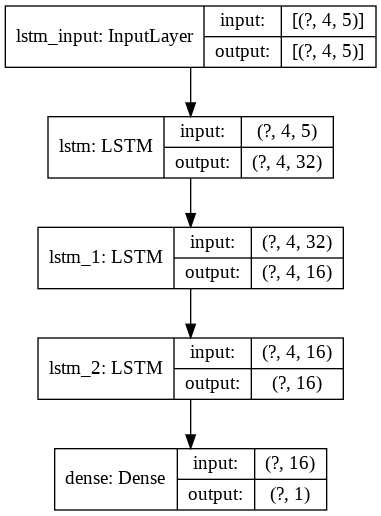

In [24]:
print(model_lat.summary())
tf.keras.utils.plot_model(model_lat, to_file='my_model.png', show_shapes=True, show_layer_names=True)

##Logtitude

In [0]:
model_lon = tf.keras.models.Sequential()
model_lon.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.1,
                                          return_sequences=True,
                                          input_shape=x_train_lon.shape[-2:]))
model_lon.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_lon.add(tf.keras.layers.LSTM(16))
model_lon.add(tf.keras.layers.Dense(future_target))

model_lon.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 16)             3136      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 10,129
Trainable params: 10,129
Non-trainable params: 0
_________________________________________________________________
None


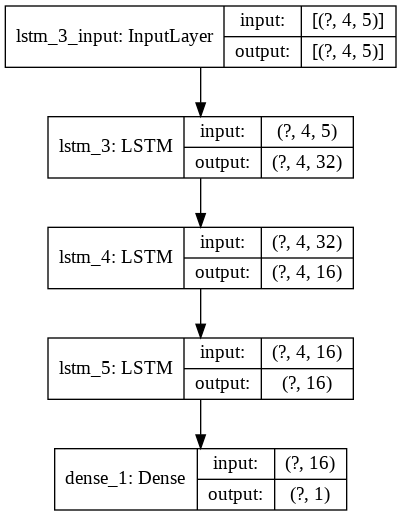

In [26]:
print(model_lon.summary())
tf.keras.utils.plot_model(model_lon, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Pressure

In [0]:
model_pres = tf.keras.models.Sequential()
model_pres.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.1,
                                    return_sequences=True,
                                       input_shape=x_train_pres.shape[-2:]))
model_pres.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_pres.add(tf.keras.layers.LSTM(16))
model_pres.add(tf.keras.layers.Dense(future_target))

model_pres.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_7 (LSTM)                (None, 4, 16)             3136      
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 10,129
Trainable params: 10,129
Non-trainable params: 0
_________________________________________________________________
None


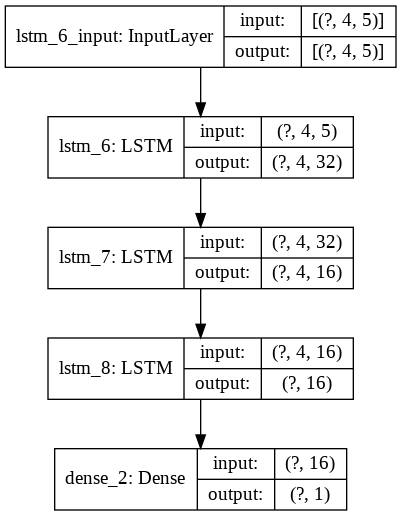

In [28]:
print(model_pres.summary())
tf.keras.utils.plot_model(model_pres, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Wind Speed

In [0]:
model_wind = tf.keras.models.Sequential()
model_wind.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.1,
                                    return_sequences=True,
                                       input_shape=x_train_lat.shape[-2:]))
model_wind.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_wind.add(tf.keras.layers.LSTM(16))
model_wind.add(tf.keras.layers.Dense(future_target))

model_wind.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 4, 32)             4864      
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 16)             3136      
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 10,129
Trainable params: 10,129
Non-trainable params: 0
_________________________________________________________________
None


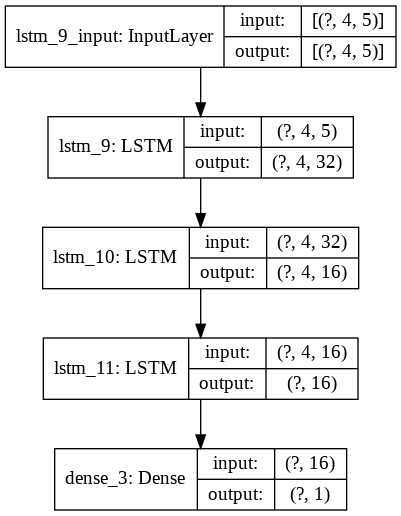

In [30]:
print(model_wind.summary())
tf.keras.utils.plot_model(model_wind, to_file='my_model.png', show_shapes=True, show_layer_names=True)

## Direction

In [0]:

model_dir = tf.keras.models.Sequential()
model_dir.add(tf.keras.layers.LSTM(32, recurrent_dropout=0.1,
                                   return_sequences=True,
                                       input_shape=x_train_dir.shape[-2:]))
model_dir.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_dir.add(tf.keras.layers.LSTM(16))
model_dir.add(tf.keras.layers.Dense(future_target))

model_dir.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=["mae", "mse"])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4, 32)             4864      
_________________________________________________________________
lstm_13 (LSTM)               (None, 4, 16)             3136      
_________________________________________________________________
lstm_14 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 10,129
Trainable params: 10,129
Non-trainable params: 0
_________________________________________________________________
None


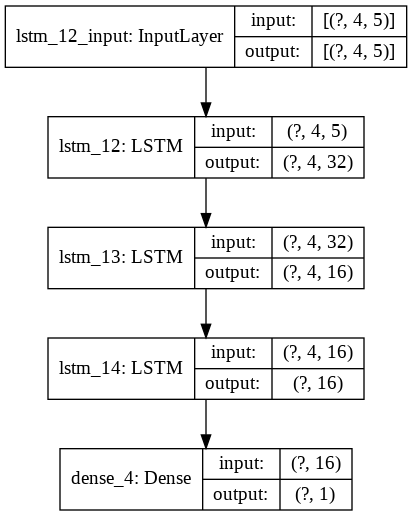

In [32]:

print(model_dir.summary())
tf.keras.utils.plot_model(model_dir, to_file='my_model.png', show_shapes=True, show_layer_names=True)

# Training

## Parameters

In [33]:
EPOCH_STEPS = len(x_train_lat) / BATCH_SIZE
VAL_STEPS = len(x_val_lat) / BATCH_SIZE
EPOCHS = 100
PATIENCE = 10

print(EPOCH_STEPS)
print(VAL_STEPS)

828.625
221.375


## Latitude

In [34]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# Set callback functions to early stop training and save the best model so far
callbacks_lat = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_lat.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_lat.fit(train_data_lat, epochs=EPOCHS, 
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                  validation_data=val_data_lat,
                                   callbacks=callbacks_lat)


Train for 828.625 steps, validate for 221.375 steps
Epoch 1/100


Using TensorFlow backend.


829/828 [==============================] - 23s 27ms/step - loss: 0.0494 - mae: 0.0495 - mse: 0.0061 - val_loss: 0.0292 - val_mae: 0.0292 - val_mse: 0.0013
Epoch 2/100
829/828 [==============================] - 14s 16ms/step - loss: 0.0290 - mae: 0.0290 - mse: 0.0014 - val_loss: 0.0388 - val_mae: 0.0386 - val_mse: 0.0022
Epoch 3/100
829/828 [==============================] - 14s 17ms/step - loss: 0.0260 - mae: 0.0261 - mse: 0.0012 - val_loss: 0.0263 - val_mae: 0.0262 - val_mse: 0.0011
Epoch 4/100
829/828 [==============================] - 14s 17ms/step - loss: 0.0237 - mae: 0.0237 - mse: 0.0010 - val_loss: 0.0235 - val_mae: 0.0233 - val_mse: 9.3932e-04
Epoch 5/100
829/828 [==============================] - 14s 16ms/step - loss: 0.0218 - mae: 0.0218 - mse: 8.6344e-04 - val_loss: 0.0259 - val_mae: 0.0258 - val_mse: 0.0011
Epoch 6/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0206 - mae: 0.0207 - mse: 7.7005e-04 - val_loss: 0.0214 - val_mae: 0.0214 - val_mse: 7.042

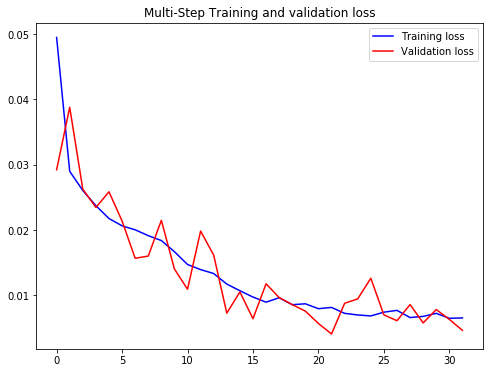

In [35]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Longtitude

In [36]:
# Set# Set callback functions to early stop training and save the best model so far
callbacks_lon = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_lon.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_lon.fit(train_data_lon, epochs=EPOCHS,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                   validation_data=val_data_lon,
                                   callbacks=callbacks_lon)

Train for 828.625 steps, validate for 221.375 steps
Epoch 1/100
829/828 [==============================] - 19s 23ms/step - loss: 0.0626 - mae: 0.0626 - mse: 0.0103 - val_loss: 0.0185 - val_mae: 0.0183 - val_mse: 6.1003e-04
Epoch 2/100
829/828 [==============================] - 14s 16ms/step - loss: 0.0213 - mae: 0.0213 - mse: 7.6774e-04 - val_loss: 0.0173 - val_mae: 0.0172 - val_mse: 5.3048e-04
Epoch 3/100
829/828 [==============================] - 14s 16ms/step - loss: 0.0196 - mae: 0.0196 - mse: 6.7255e-04 - val_loss: 0.0148 - val_mae: 0.0147 - val_mse: 4.0039e-04
Epoch 4/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0180 - mae: 0.0181 - mse: 5.7112e-04 - val_loss: 0.0127 - val_mae: 0.0127 - val_mse: 3.1729e-04
Epoch 5/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0173 - mae: 0.0173 - mse: 5.2094e-04 - val_loss: 0.0152 - val_mae: 0.0152 - val_mse: 4.1033e-04
Epoch 6/100
829/828 [==============================] - 13s 16ms/step - loss: 

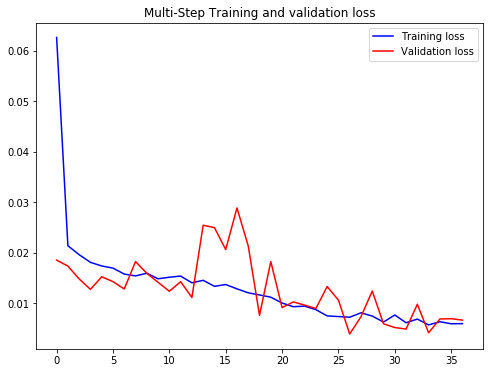

In [37]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Predict a multi-step future: 
Let's now have a look at how well your network has learnt to predict the future.

## Wind Pressure

In [38]:
# Set callback functions to early stop training and save the best model so far
callbacks_pres = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_pres.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_pres.fit(train_data_pres, epochs=EPOCHS,
                                    steps_per_epoch=EPOCH_STEPS,
                                    validation_steps=VAL_STEPS,
                                    validation_data=val_data_pres,
                                    callbacks=callbacks_pres)

Train for 828.625 steps, validate for 221.375 steps
Epoch 1/100
829/828 [==============================] - 18s 22ms/step - loss: 0.0730 - mae: 0.0730 - mse: 0.0177 - val_loss: 0.0569 - val_mae: 0.0568 - val_mse: 0.0050
Epoch 2/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0477 - mae: 0.0477 - mse: 0.0042 - val_loss: 0.0470 - val_mae: 0.0469 - val_mse: 0.0039
Epoch 3/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0463 - mae: 0.0463 - mse: 0.0040 - val_loss: 0.0448 - val_mae: 0.0447 - val_mse: 0.0038
Epoch 4/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0445 - mae: 0.0445 - mse: 0.0036 - val_loss: 0.0484 - val_mae: 0.0484 - val_mse: 0.0043
Epoch 5/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0402 - mae: 0.0402 - mse: 0.0030 - val_loss: 0.0323 - val_mae: 0.0322 - val_mse: 0.0023
Epoch 6/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0021 -

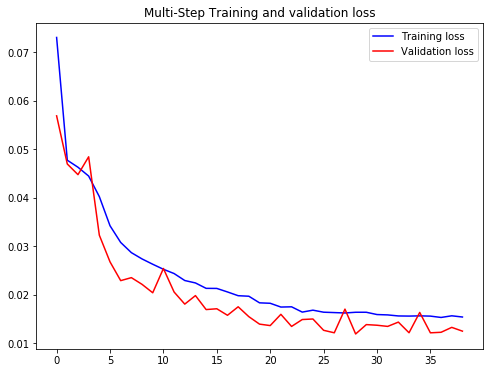

In [39]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Wind Speed

In [40]:
# Set callback functions to early stop training and save the best model so far
callbacks_wind = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_wind.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_wind.fit(train_data_wind, epochs=EPOCHS,
                                    steps_per_epoch=EPOCH_STEPS,
                                    validation_steps=VAL_STEPS,
                                    validation_data=val_data_wind,
                                    callbacks=callbacks_wind)

Train for 828.625 steps, validate for 221.375 steps
Epoch 1/100
829/828 [==============================] - 19s 22ms/step - loss: 0.0845 - mae: 0.0845 - mse: 0.0136 - val_loss: 0.0566 - val_mae: 0.0565 - val_mse: 0.0058
Epoch 2/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0626 - mae: 0.0626 - mse: 0.0070 - val_loss: 0.0510 - val_mae: 0.0509 - val_mse: 0.0048
Epoch 3/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0518 - mae: 0.0518 - mse: 0.0049 - val_loss: 0.0358 - val_mae: 0.0358 - val_mse: 0.0025
Epoch 4/100
829/828 [==============================] - 14s 16ms/step - loss: 0.0312 - mae: 0.0312 - mse: 0.0019 - val_loss: 0.0219 - val_mae: 0.0219 - val_mse: 9.6574e-04
Epoch 5/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0258 - mae: 0.0258 - mse: 0.0014 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 8.8486e-04
Epoch 6/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0248 - mae: 0.0248 - mse: 

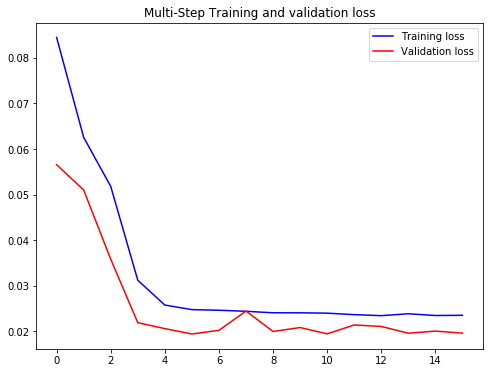

In [41]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

## Direction

In [42]:

# Set callback functions to early stop training and save the best model so far
callbacks_dir = [EarlyStopping(monitor='val_loss', patience=PATIENCE),
              ModelCheckpoint(filepath='best_model_dir.h5', monitor='val_loss', save_best_only=True)]

multi_step_history = model_dir.fit(train_data_dir, epochs=EPOCHS,
                                   steps_per_epoch=EPOCH_STEPS,
                                   validation_steps=VAL_STEPS,
                                    validation_data=val_data_dir,
                                   callbacks=callbacks_dir)

Train for 828.625 steps, validate for 221.375 steps
Epoch 1/100
829/828 [==============================] - 19s 23ms/step - loss: 0.1715 - mae: 0.1715 - mse: 0.0764 - val_loss: 0.1328 - val_mae: 0.1328 - val_mse: 0.0550
Epoch 2/100
829/828 [==============================] - 13s 16ms/step - loss: 0.1338 - mae: 0.1338 - mse: 0.0572 - val_loss: 0.1182 - val_mae: 0.1181 - val_mse: 0.0388
Epoch 3/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0958 - mae: 0.0959 - mse: 0.0420 - val_loss: 0.0865 - val_mae: 0.0865 - val_mse: 0.0330
Epoch 4/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0831 - mae: 0.0832 - mse: 0.0412 - val_loss: 0.0844 - val_mae: 0.0844 - val_mse: 0.0334
Epoch 5/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0820 - mae: 0.0820 - mse: 0.0412 - val_loss: 0.0807 - val_mae: 0.0807 - val_mse: 0.0335
Epoch 6/100
829/828 [==============================] - 13s 16ms/step - loss: 0.0798 - mae: 0.0798 - mse: 0.0411 -

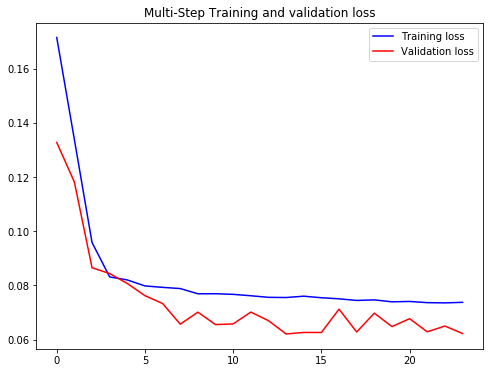

In [43]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

# Testing Network: Multistep Trajectory and Intensity Prediction
Test network and plot paths on a map for a given storm.

In [0]:
lat_min = data_min[0]
lat_max = data_max[0]
lon_min = data_min[1]
lon_max = data_max[1]
wind_min = data_min[2]
wind_max = data_max[2]

# Helper Functions

def tensor_to_array(tensor1):
    return tensor1.numpy()

def un_normalize_lon_lat(lat, lon):
  new_lat = (lat * (lat_max-lat_min)) + lat_min
  new_lon = (lon * (lon_max-lon_min)) + lon_min
  return new_lat, new_lon

def un_normalize_wind(wind):
  new_wind = (wind * (wind_max-wind_min)) + wind_min
  return new_wind

def un_normalize_lat(lat):
  new_lat = (lat * (lat_max-lat_min)) + lat_min
  return new_lat

def un_normalize_lon(lon):
  new_lon = (lon * (lon_max-lon_min)) + lon_min
  return new_lon

def tuple_to_lists(list_tuples):
  list0 = []
  list1 = []
  for x,y in list_tuples:
    list0.append(x)
    list1.append(y)
  return list0, list1

## Storms
The following storms were used as samples for prediction

In [0]:
best_model_lat = tf.keras.models.load_model('best_model_lat.h5')
best_model_lon =  tf.keras.models.load_model('best_model_lon.h5')
best_model_wind =  tf.keras.models.load_model('best_model_wind.h5')
best_model_pres =  tf.keras.models.load_model('best_model_pres.h5')
best_model_dir =  tf.keras.models.load_model('best_model_dir.h5')

In [0]:
def get_multistep_storm_prediction(storm, start_time, timesteps):
  history = []
  expected = []
  actual = []
  
  history_wind = []
  expected_wind = []
  actual_wind = []

  for i in range(0,start_time+past_history):
    history.append(un_normalize_lon_lat(storm[i][0], storm[i][1]))
    history_wind.append(storm[i][2])

  input_x = np.array(storm[start_time:start_time+past_history])

  for i in range(start_time+past_history,start_time+past_history+timesteps,future_target):

    x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])
    output_y = np.array(storm[i+1])
    y = output_y.reshape(1, output_y.shape[0], 1)

    predicted_lat = best_model_lat.predict(x)
    predicted_lon = best_model_lon.predict(x)
    predicted_wind = best_model_wind.predict(x)
    predicted_pres = best_model_pres.predict(x)
    predicted_dir = best_model_dir.predict(x)

    new_input = list(input_x)
    del new_input[0:future_target]

    predicted = [float(predicted_lat[0][0]), float(predicted_lon[0][0]), float(predicted_wind[0][0]), float(predicted_pres[0][0]), float(predicted_dir[0][0])]
    
    expected_lat, expected_lon = un_normalize_lon_lat(storm[i][0], storm[i][1])
    actual_lat, actual_lon = un_normalize_lon_lat(predicted[0], predicted[1])

    expected.append((expected_lat, expected_lon))
    actual.append((actual_lat, actual_lon))
    expected_wind.append(un_normalize_wind(storm[i][2]))
    actual_wind.append(un_normalize_wind(predicted[2]))

    new_input.append(predicted)

    input_x = np.array(new_input)

  mae_lat = abs(storm[i][0] - predicted[0])
  mae_lon = abs(storm[i][1] - predicted[1])
  mae_wind = abs(storm[i][2] - predicted[2])
  mae_pres = abs(storm[i][3] - predicted[3])
  mae_dir = abs(storm[i][4] - predicted[4])

  mse_lat = (storm[i][0] - predicted[0])**2
  mse_lon = (storm[i][1] - predicted[1])**2
  mse_wind = (storm[i][2] - predicted[2])**2
  mse_pres = (storm[i][3] - predicted[3])**2
  mse_dir = (storm[i][4] - predicted[4])**2

  total_mae = (mae_lat + mae_lon + mae_wind + mae_pres + mae_dir)/5
  total_mse = (mse_lat + mse_lon + mse_wind + mse_pres + mse_dir)/5

  return history, actual, expected, history_wind, actual_wind, expected_wind, total_mae, total_mse

In [0]:

def plot_hurricane_prediction_map(i, start_time):
  name = hurricane_SID[i]
  storm = retreiveDatasetByName(name, df, dataset)

  history, actual, expected, history_pres, actual_pres, expected_pres, total_mae, total_mse = get_multistep_storm_prediction(storm, start_time, 4)
  print(history)
  print(actual)
  print(expected)

  print(total_mae)

  actual = [history[-1]] + actual
  expected = [history[-1]] + expected
  history_lat, history_lon = tuple_to_lists(history)
  actual_lat, actual_lon = tuple_to_lists(actual)
  expected_lat, expected_lon = tuple_to_lists(expected)

  history_lat = np.array(history_lat)
  history_lon = np.array(history_lon)

  actual_lat = np.array(actual_lat)
  actual_lon = np.array(actual_lon)

  expected_lat = np.array(expected_lat)
  expected_lon = np.array(expected_lon)

  multi_step_plot(history_lat, expected_lat[1:], actual_lat[0:-1], name+" Latitude")
  multi_step_plot(history_lon, expected_lon[1:], actual_lon[0:-1], name+" Longtitude")
  multi_step_plot(np.array(history_pres), np.array(expected_pres), np.array(actual_pres), name+" Intensity")

  ave_lat = sum(p[0] for p in actual)/len(actual)
  ave_lon = sum(p[1] for p in actual)/len(actual)

  # Load map centred on average coordinates
  my_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=8)

  plot_path("red", actual,actual_pres, my_map)
  plot_path("blue", expected, expected_pres, my_map)
  plot_path("black", history, history_pres, my_map)

  display(my_map)

In [48]:
def prediction_mae_mse(timesteps):
  sum_mae = 0
  sum_mse = 0
  num = 0
  for i in range(TRAIN_SPLIT, len(hurricanes_by_SID)):
    history, actual, expected, history_pres, actual_pres, expected_pres, total_mae, total_mse = get_multistep_storm_prediction(hurricanes_by_SID[i], 0, timesteps)
    sum_mae += total_mae
    sum_mse += total_mse
    num += 1
  return (sum_mae/num), (sum_mse/num)

for i in range(1,5):
  print("MAE and MSE at timestep: ", i)
  print(prediction_mae_mse(i))
  print()

MAE and MSE at timestep:  1
(0.014867093920695325, 0.0029412982942754184)

MAE and MSE at timestep:  2
(0.03230999891260689, 0.011330553661759534)

MAE and MSE at timestep:  3
(0.041021346136039874, 0.012270914626567504)

MAE and MSE at timestep:  4
(0.05196281051184297, 0.017360013168098522)



### Storm ID: 2016256N20312

[(20.0, -48.5), (20.5, -49.3), (21.2, -50.2), (22.2, -50.60000000000001)]
[(23.059509371221065, -50.773759615421284), (23.759522852301597, -51.009208559989915), (24.284211483597755, -51.37329773902893), (24.687066239118575, -51.825255072116846)]
[(23.0, -51.2), (23.9, -51.7), (24.8, -52.10000000000001), (26.0, -52.39999999999999)]
0.03782898451752161


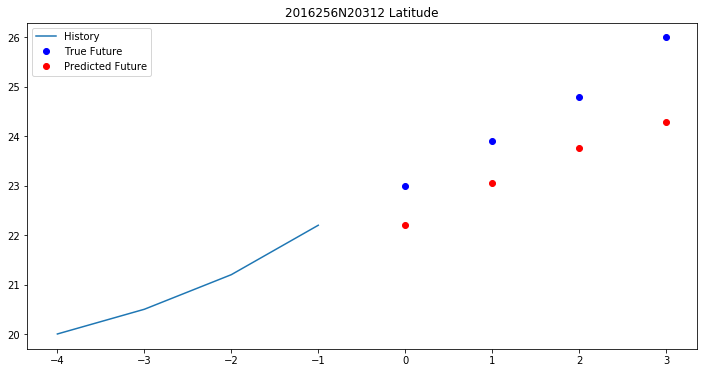

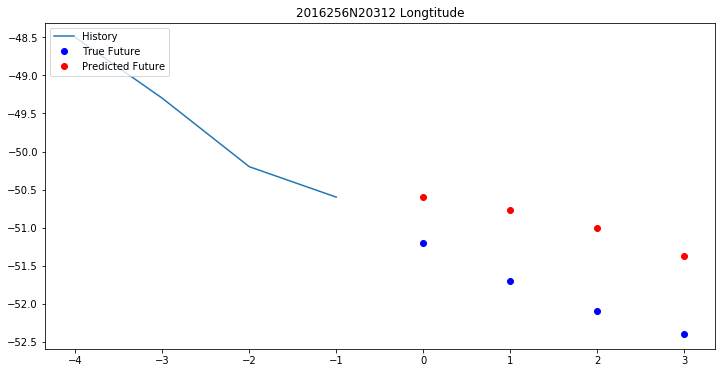

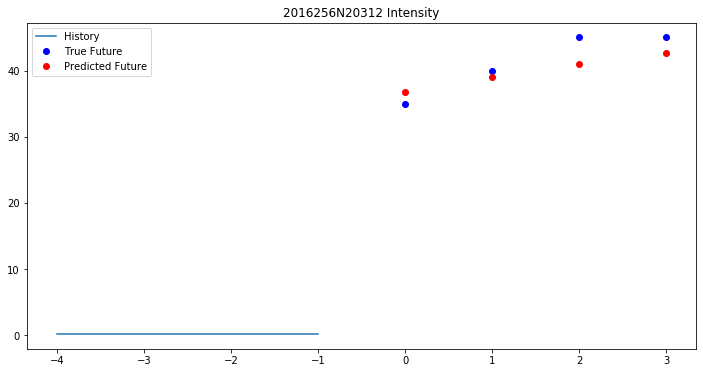

421


In [49]:
index = 421
plot_hurricane_prediction_map(index, 0)
print(index)

###Storm ID: 2012255N16322

[(15.5, -38.0), (15.599999999999998, -39.39999999999999), (15.8, -40.8), (16.0, -41.89999999999999)]
[(16.339325261116027, -42.80204015970229), (16.670742017030715, -43.69717193841933), (16.983372446894645, -44.631096112728116), (17.275963750481605, -45.580048608779904)]
[(16.4, -42.8), (16.9, -43.7), (17.5, -44.8), (18.1, -45.89999999999999)]
0.03444736875394579


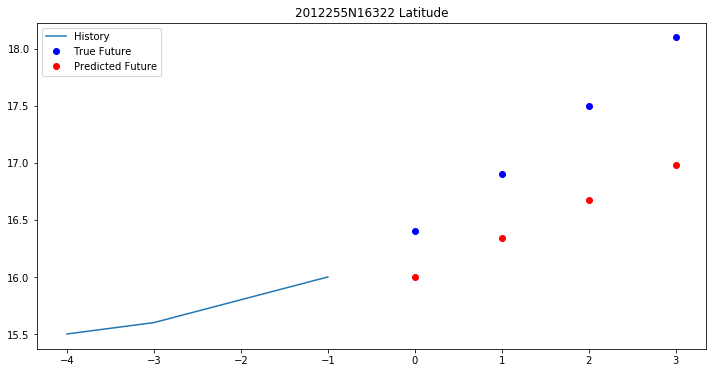

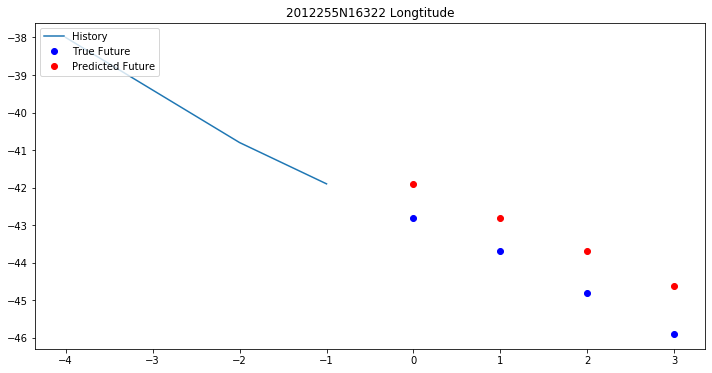

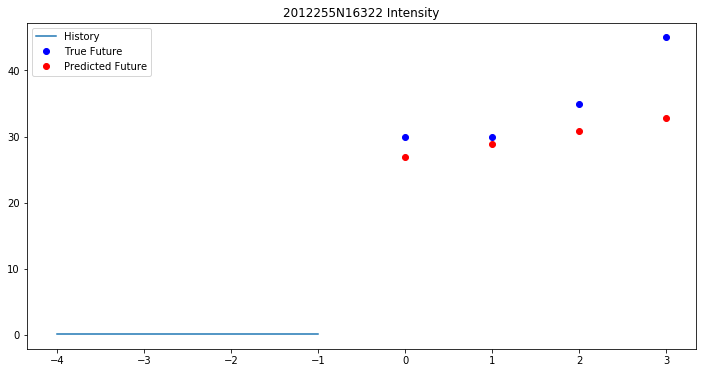

373


In [50]:
index = 373
plot_hurricane_prediction_map(index, 0)
print(index)

###Storm ID: 2013321N24308

[(23.9, -52.39999999999999), (24.3, -52.7), (25.0, -52.89999999999999), (26.0, -52.89999999999999)]
[(26.694002997875213, -52.67259160280227), (27.583994549512862, -52.10391927957534), (28.332370471954345, -51.55001603364944), (29.02721473276615, -50.81296051740645)]
[(27.1, -52.7), (28.3, -52.7), (29.1, -53.39999999999999), (29.7, -54.0)]
0.18295586857257487


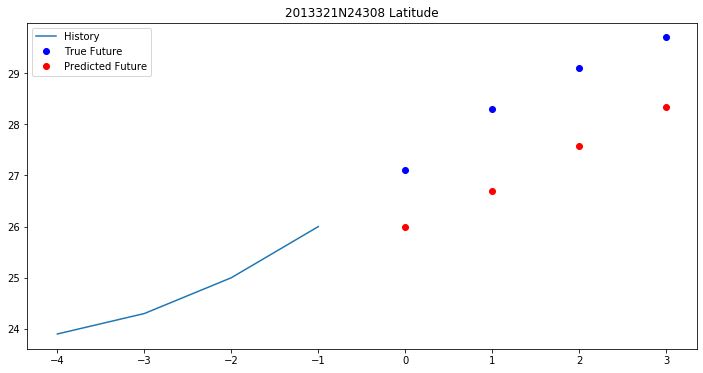

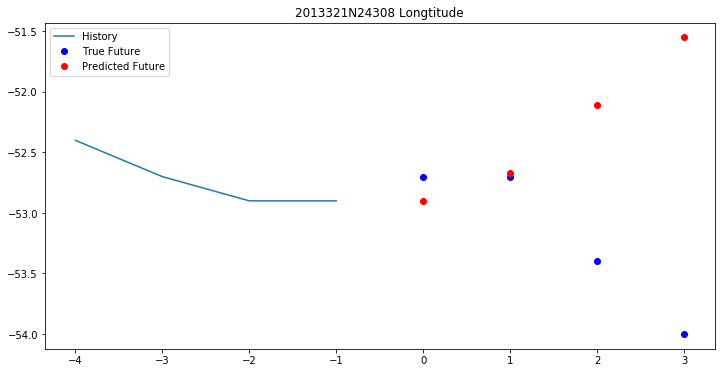

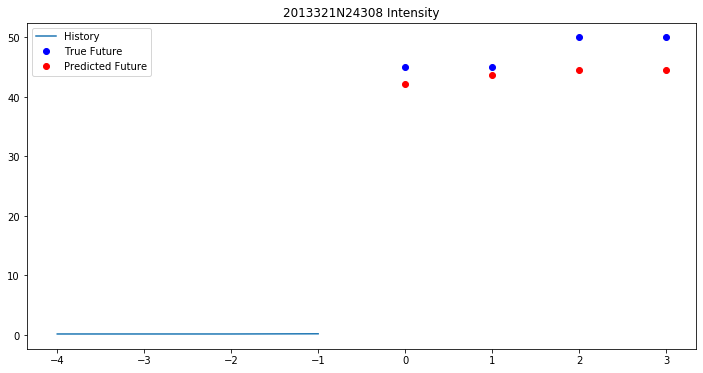

389


In [62]:
index = 389
plot_hurricane_prediction_map(index, 0)
print(index)

###Random Storm

[(31.8, -39.5), (32.3, -38.60000000000001), (32.9, -37.3), (32.7, -38.5)]
[(31.905235600471496, -40.09396486282348), (31.365566354990005, -40.88319135904311), (31.096460324525832, -40.6711686849594), (30.936291140317916, -40.1718246102333)]
[(32.3, -39.5), (31.5, -39.5), (31.3, -39.5), (31.0, -39.60000000000001)]
0.05727239793852408


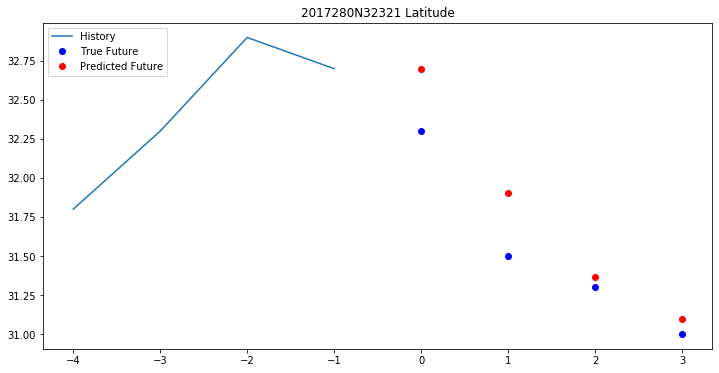

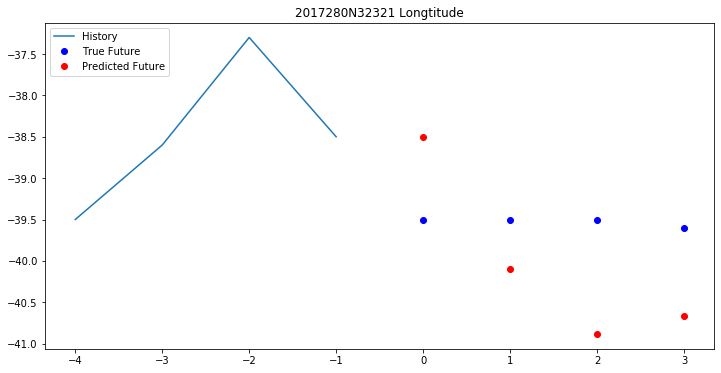

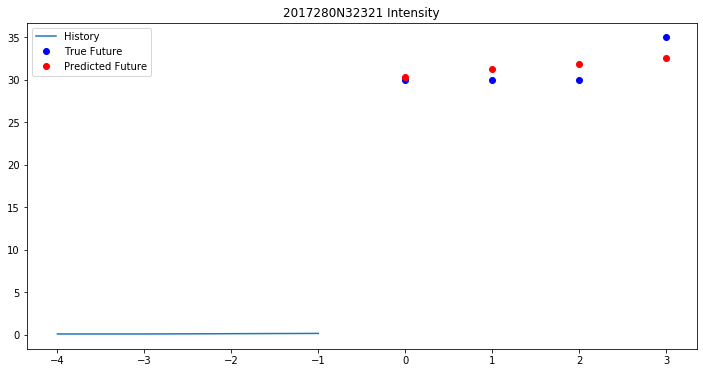

439


In [73]:
# RANDOM:
index = rand.randrange(TRAIN_SPLIT,len(hurricane_SID))
plot_hurricane_prediction_map(index, 0)
print(index)

## Comparison to NHC and Grid-Based RNN approach
Comparison of 48-h Forecast Error (n mi) with grid-based RNN and the National Hurricane Center.


*   Grid-Based RNN implemented by Alemany et al, 2018: http://arxiv.org/abs/1802.02548
*   National Hurricane Center GPRA Track Goal Veriﬁcation: https://www.nhc.noaa.gov/verification/ verify8.shtml


In [0]:
def multistep_storm_prediction(storm, start_time, timesteps):

  actual_coord = []
  expected_coord = []

  actual_intensity = []
  expected_intensity = []

  input_x = np.array(storm[start_time:start_time+past_history])

  for i in range(start_time+past_history,start_time+past_history+timesteps,future_target):

    x = input_x.reshape(1, input_x.shape[0], input_x.shape[1])

    predicted_lat = best_model_lat.predict(x)
    predicted_lon = best_model_lon.predict(x)
    predicted_wind = best_model_wind.predict(x)
    predicted_pres = best_model_pres.predict(x)
    predicted_dir = best_model_dir.predict(x)

    new_input = list(input_x)
    del new_input[0]

    predicted = [float(predicted_lat[0][0]), float(predicted_lon[0][0]), float(predicted_wind[0][0]), float(predicted_pres[0][0]), float(predicted_dir[0][0])]

    new_input.append(predicted)

    input_x = np.array(new_input)
    
    expected_coord.append(un_normalize_lon_lat(storm[i][0], storm[i][1]))
    actual_coord.append(un_normalize_lon_lat(predicted[0], predicted[1]))

    expected_intensity.append(un_normalize_wind(storm[i][2]))
    actual_intensity.append(un_normalize_wind(predicted[2]))

    
  
  return expected_coord, actual_coord, expected_intensity, actual_intensity
  


In [58]:
import geopy.distance
from statistics import mean

errors_by_year = []
for i in range (2003,2013):
  huricanes_by_year = retreiveSIDByYear(i)
  dist_sum = 0
  num_dist = 0
  print(huricanes_by_year[0])
  for sid in huricanes_by_year:
    index = hurricane_SID.index(sid)
    expected_coord, actual_coord, expected_intensity, actual_intensity = multistep_storm_prediction(hurricanes_by_SID[index], start_time=0, timesteps=8)
    for k in range(len(expected_coord)):
      dist = geopy.distance.vincenty(actual_coord[k], expected_coord[k]).mi
      dist_sum += dist
      num_dist += 1
  avg_error_year = dist_sum/num_dist
  errors_by_year.append(avg_error_year)


print(errors_by_year)
print(mean(errors_by_year))

2003108N29294
2004214N30282
2005160N17276
2006161N20275
2007127N36286
2008185N13337
2009147N31285
2010176N16278
2011179N20267
2012140N33283
[210.66327501306048, 172.4241940211998, 174.37870698598917, 111.94405399022632, 211.27322823376932, 204.87990629823688, 166.31110977939994, 222.0367190019881, 206.5762180993116, 200.39673413743225]
188.0884145560614


In [59]:
url = 'https://raw.githubusercontent.com/emma-howard/hurricane-project/master/Dataset/NHC_GridBased_Errors.csv'
nhc_data = pd.read_csv(url, header=0)

nhc_data.head()

,Year,GridBased,NHCOfficialError
0,2003,45,107.4
1,2004,60,94.4
2,2005,55,101.2
3,2006,65,96.6
4,2007,60,86.2


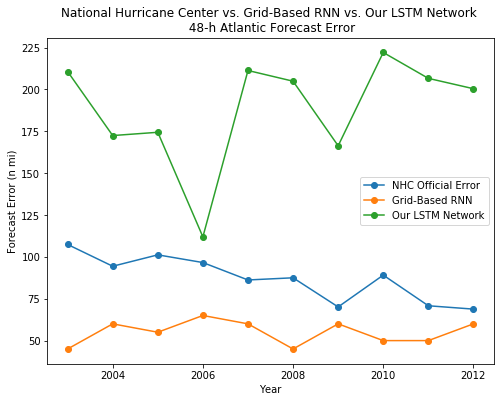

In [61]:
x = [i for i in range(2003, 2013)]

# NHC Official
y1 = nhc_data.NHCOfficialError
plt.plot(x, y1, marker='o', label = "NHC Official Error") 

# Grid-Base RNN
y2 = nhc_data.GridBased
plt.plot(x, y2, marker='o', label = "Grid-Based RNN") 
  
# Our LSTM Implementation 
y3 = errors_by_year   
plt.plot(x, y3, marker='o', label = "Our LSTM Network") 

plt.xlabel('Year') 
plt.ylabel('Forecast Error (n mi)') 
plt.title('National Hurricane Center vs. Grid-Based RNN vs. Our LSTM Network \n 48-h Atlantic Forecast Error') 

plt.legend()  
plt.show() 